In [1]:
import websocket
import json
import time
import threading
import uuid
import pandas as pd
from datetime import datetime
import logging

class TradingViewDataFetcher:
    def __init__(self, log_level=logging.WARNING):
        """
        Initialize the TradingView data fetcher with configurable logging.
        
        Args:
            log_level: Logging level (default: WARNING to suppress info messages)
        """
        logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
        
        # Default WebSocket URL (can be changed if needed)
        self.ws_url = "wss://prodata.tradingview.com/socket.io/websocket"
        
        # Default headers
        self.headers = {
            "Origin": "https://www.tradingview.com",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }

    def fetch_data(self, symbol, exchange="NASDAQ", interval="D", num_bars=100, timeout=20, alt_urls=None):
        """
        Fetch historical price data from TradingView.
        
        Args:
            symbol: Trading symbol (e.g., "AAPL")
            exchange: Exchange name (e.g., "NASDAQ")
            interval: Time interval (e.g., "D" for daily, "W" for weekly, "M" for monthly, 
                     or "1" for 1 minute, "5" for 5 minutes, etc.)
            num_bars: Number of bars to request
            timeout: Maximum time to wait for data in seconds
            alt_urls: List of alternative WebSocket URLs to try if the primary fails
            
        Returns:
            pandas.DataFrame: DataFrame containing OHLCV data
        """
        urls_to_try = [self.ws_url]
        if alt_urls:
            urls_to_try.extend(alt_urls)
        
        for url in urls_to_try:
            self.logger.info(f"Trying WebSocket URL: {url}")
            
            # Reset state for each attempt
            self.session_id = f"qs_{uuid.uuid4().hex[:12]}"
            self.chart_session = f"cs_{uuid.uuid4().hex[:12]}"
            self.received_data = []
            self.error_occurred = False
            
            # Create and start WebSocket
            websocket.enableTrace(False)  # Set to True for verbose WebSocket logs
            ws = websocket.WebSocketApp(
                url,
                header=[f"{k}: {v}" for k, v in self.headers.items()],
                on_open=self._on_open(symbol, exchange, interval, num_bars),
                on_message=self._on_message,
                on_error=self._on_error,
                on_close=self._on_close
            )
            
            wst = threading.Thread(target=ws.run_forever)
            wst.daemon = True
            wst.start()
            
            try:
                # Wait for data
                start_time = time.time()
                while time.time() - start_time < timeout:
                    if self.error_occurred:
                        self.logger.error("Connection error detected, trying next URL if available")
                        break
                    
                    if len(self.received_data) >= num_bars/2:
                        self.logger.info(f"Received sufficient data: {len(self.received_data)} bars")
                        break
                        
                    time.sleep(0.5)
                
                # If we have data, process and return it
                if self.received_data:
                    ws.close()
                    return self._process_data()
                
            except KeyboardInterrupt:
                self.logger.info("Interrupted by user")
            finally:
                ws.close()
        
        # If we get here, all URLs failed
        self.logger.error("Failed to retrieve data from all WebSocket URLs")
        return None

    def _process_data(self):
        """Process the received data into a DataFrame."""
        df = pd.DataFrame(self.received_data)
        if not df.empty:
            df['Date'] = pd.to_datetime(df['Date'], unit='s')
            df = df.sort_values('Date')
            #df.set_index('Date', inplace=True)
            return df
        return None

    def _on_open(self, symbol, exchange, interval, num_bars):
        """Prepare the on_open callback with the required parameters."""
        def on_open_callback(ws):
            self.logger.info("WebSocket connection established")
            
            def run():
                try:
                    self._send_message(ws, "set_auth_token", ["unauthorized_user_token"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_session", [self.chart_session, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "switch_timezone", [self.chart_session, "Etc/UTC"])
                    time.sleep(0.2)
                    
                    full_symbol = f"{exchange}:{symbol}"
                    symbol_payload = json.dumps({"symbol": full_symbol, "adjustment": "splits"})
                    self._send_message(ws, "resolve_symbol", [self.chart_session, "symbol_1", f"={symbol_payload}"])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "create_series", [self.chart_session, "s1", "s1", "symbol_1", interval, num_bars, ""])
                    time.sleep(0.2)
                    
                    self._send_message(ws, "chart_create_study", [self.chart_session, "st1", "st1", "sds_1", full_symbol, interval, num_bars, ""])
                    
                    self.logger.info(f"Requested {num_bars} {interval} bars for {full_symbol}")
                except Exception as e:
                    self.logger.error(f"Error in initialization sequence: {e}")
            
            thread = threading.Thread(target=run)
            thread.daemon = True
            thread.start()
        
        return on_open_callback

    def _send_message(self, ws, method, params):
        """Send a properly formatted message to TradingView WebSocket."""
        try:
            data = json.dumps({"m": method, "p": params})
            message = f"~m~{len(data)}~m~{data}"
            ws.send(message)
            self.logger.debug(f"Sent: {method} - {params[:50]}{'...' if len(str(params)) > 50 else ''}")
        except Exception as e:
            self.logger.error(f"Error sending message {method}: {e}")

    def _on_message(self, ws, message):
        """Handle incoming WebSocket messages."""
        if message == "~h~":
            self.logger.debug("Received heartbeat, sending pong")
            ws.send("~h~")
            return
        
        if not message.startswith("~m~"):
            return
        
        try:
            msg_parts = message.split("~m~")
            for i in range(0, len(msg_parts)):
                if msg_parts[i] and msg_parts[i].isdigit() and i + 1 < len(msg_parts):
                    content = msg_parts[i+1]
                    if content and content.startswith("{"):
                        try:
                            data = json.loads(content)
                            
                            if isinstance(data, dict) and data.get("m") == "timescale_update":
                                self.logger.debug("Found timescale_update message")
                                payload = data.get("p", [])
                                if len(payload) > 1 and isinstance(payload[1], dict):
                                    for series_id, series_data in payload[1].items():
                                        if "s" in series_data and isinstance(series_data["s"], list):
                                            bars_count = len(series_data["s"])
                                            self.logger.debug(f"Found {bars_count} price bars")
                                            
                                            for bar in series_data["s"]:
                                                if "v" in bar and len(bar["v"]) >= 5:
                                                    ts, o, h, l, c = bar["v"][:5]
                                                    volume = bar["v"][5] if len(bar["v"]) > 5 else None
                                                    self.received_data.append({
                                                        "Date": ts,
                                                        "Open": o,
                                                        "High": h,
                                                        "Low": l,
                                                        "Close": c,
                                                        "Volume": volume
                                                    })
                        except json.JSONDecodeError:
                            self.logger.debug(f"Failed to parse JSON: {content[:50]}...")
        except Exception as e:
            self.logger.error(f"Error processing message: {e}")

    def _on_error(self, ws, error):
        """Handle WebSocket errors."""
        self.error_occurred = True
        self.logger.error(f"WebSocket error: {error}")

    def _on_close(self, ws, close_status_code, close_msg):
        """Handle WebSocket connection close."""
        self.logger.debug(f"WebSocket closed: {close_status_code} - {close_msg}")


# Example usage
def get_data(symbol, exchange="NASDAQ", interval="D", bars=5000, log_level=logging.WARNING):
    """
    Simple function to fetch data from TradingView.
    
    Args:
        symbol: Trading symbol (e.g., "AAPL")
        exchange: Exchange name (default: "NASDAQ")
        interval: Time interval (default: "D" for daily)
        bars: Number of bars to request (default: 5000)
        log_level: Logging level (default: WARNING - minimal output)
    
    Returns:
        pandas.DataFrame: DataFrame with OHLCV data or None if failure
    """
    fetcher = TradingViewDataFetcher(log_level=log_level)
    
    # Alternative URLs to try if the primary fails
    alt_urls = [
        "wss://data.tradingview.com/socket.io/websocket",
        "wss://s.tradingview.com/socket.io/websocket"
    ]
    
    return fetcher.fetch_data(
        symbol=symbol,
        exchange=exchange,
        interval=interval,
        num_bars=bars,
        alt_urls=alt_urls
    )
import re 

def occ_to_yahoo(occ):
    """
    Convert OCC option symbol (e.g., TSLA250613P00300000) to Yahoo format (e.g., TSLA250613P300.0).
    Handles tickers of any length and all valid strike formats, always includes one decimal.
    """
    m = re.match(r'^([A-Z0-9]{1,6})(\d{6})([CP])(\d{8})$', occ)
    if not m:
        raise ValueError("Invalid OCC option symbol format")
    symbol, date, opt_type, strike_raw = m.groups()
    strike = int(strike_raw) / 1000
    strike_str = f"{strike:.1f}"  # Always one decimal place

    yahoo = f"{symbol}{date}{opt_type}{strike_str}"
    return yahoo




In [2]:
import yfinance as yf
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows

## Fetching options chain for a specific ticker
ticker = "TSLA"
expiry = "2025-06-20"  

def get_options_chain(symbol):
    stock = yf.Ticker(symbol)
    all_options = []
    for expiry in stock.options:
        chain = stock.option_chain(expiry)
        calls = chain.calls.copy()
        puts = chain.puts.copy()
        calls['type'] = 'call'
        puts['type'] = 'put'
        calls['expiry'] = expiry
        puts['expiry'] = expiry
        all_options.append(calls)
        all_options.append(puts)
    options_chain = pd.concat(all_options, ignore_index=True)
    return options_chain.sort_values(by="expiry", ascending=True)

## Adjusts returned Frame 
df = get_options_chain(ticker)
print(df["expiry"].unique()) 

# --- Safe access for info fields ---
ticker_obj = yf.Ticker(ticker)
info = ticker_obj.info

current_price = info.get('currentPrice')
if current_price is not None:
    print(f"{ticker} Current price : {current_price}")
else:
    print(f"{ticker} Current price : Not available")

exchange = info.get('exchange')
if exchange is not None:
    print(f"Exchange : {exchange}")
else:
    print("Exchange : Not available")
# -----------------------------------

df = df[df["expiry"] == expiry]
df.sort_values(by="strike", ascending=True, inplace=True)
key_cols = ['contractSymbol','lastTradeDate','strike', 'type', 'expiry', 'lastPrice', 'bid', 'ask', 'volume', 'openInterest','impliedVolatility']
df = df[[col for col in key_cols if col in df.columns]]

from IPython.display import display, HTML
html = f"""
<div style='height: 200px; overflow: auto; width: fit-content'>
    <style>
        table {{ border-collapse: collapse; }}
        thead th {{
            position: sticky;
            top: 0;
            background-color: Black;
            z-index: 1;
        }}
    </style>
    {df.to_html(index=False)}
</div>
"""


['2025-06-20' '2025-06-27' '2025-07-03' '2025-07-11' '2025-07-18'
 '2025-07-25' '2025-08-01' '2025-08-15' '2025-09-19' '2025-10-17'
 '2025-11-21' '2025-12-19' '2026-01-16' '2026-03-20' '2026-06-18'
 '2026-09-18' '2026-12-18' '2027-01-15' '2027-06-17' '2027-12-17']
TSLA Current price : 329.13
Exchange : NMS


In [5]:
contract = 'TSLA250620P00330000' # change for contracts
##___________________________________________________________________________________________________________________________________________________________________________________

tvcontract = occ_to_yahoo(contract)  # Convert OCC to Yahoo format
data = get_data(tvcontract, exchange="OPRA", interval="1", bars=5000)

data
print(tvcontract)


TSLA250620P330.0


In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.index = data.index - pd.Timedelta(hours=4)
data.tail(10)

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0


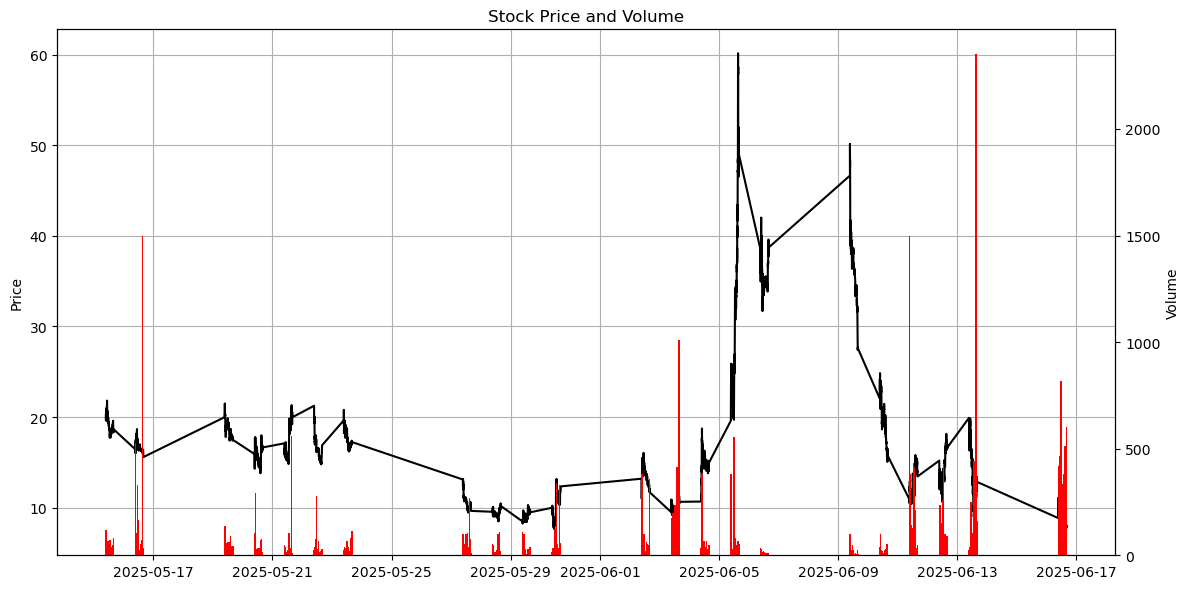

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0


In [7]:

import pandas as pd
import matplotlib.pyplot as plt



import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price
ax1.plot(data.index, data['Close'], color='black', label='Close Price')
ax1.set_ylabel('Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Stock Price and Volume')
ax1.grid(True)

# Create a secondary y-axis for volume
ax2 = ax1.twinx()
ax2.bar(data.index, data['Volume'], color='red', alpha=1, label='Volume', width =0.05)
ax2.set_ylabel('Volume', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
plt.show()

data.tail(10)

In [8]:
from IPython.display import display, HTML

# Get the last 10 rows as HTML
html_table = data.to_html()

# Wrap in a scrollable div
scrollable_html = f'''
<div style="max-height:300px; overflow:auto; border:1px solid #ccc;">
    {html_table}
</div>
'''

display(HTML(scrollable_html))


,Open,High,Low,Close,Volume
Date,,,,,
2025-05-15 09:41:00,20.25,20.25,20.25,20.25,1.0
2025-05-15 09:42:00,20.10,20.10,20.00,20.00,11.0
2025-05-15 09:43:00,20.00,20.01,19.94,19.94,7.0
2025-05-15 09:44:00,19.65,19.65,19.63,19.65,26.0
2025-05-15 09:45:00,19.57,19.74,19.57,19.74,8.0
2025-05-15 09:46:00,20.00,20.35,20.00,20.35,43.0
2025-05-15 09:48:00,20.45,20.55,20.45,20.55,4.0
2025-05-15 09:49:00,20.70,20.73,20.70,20.73,101.0
2025-05-15 09:50:00,20.63,20.75,20.63,20.70,6.0


In [9]:
from datetime import datetime
##___________________________________________________________________________________________________________________________________________________________________________________
# Manual start datetime input
dt1 = "2025-06-10 09:30:00"
##___________________________________________________________________________________________________________________________________________________________________________________

# Get the most recent index from your DataFrame (assuming it's a pandas DatetimeIndex)
dt2 = data.index[-1]

# Convert dt1 to datetime object
date1 = datetime.strptime(dt1, "%Y-%m-%d %H:%M:%S")
date2 = dt2  # already a datetime object

# Calculate the difference in days with 10 decimals
days_diff = (date2 - date1).total_seconds() / 86400

print(f"Number of days between {dt1} and {date2}: {days_diff:.10f} days")


Number of days between 2025-06-10 09:30:00 and 2025-06-16 15:59:00: 6.2701388889 days


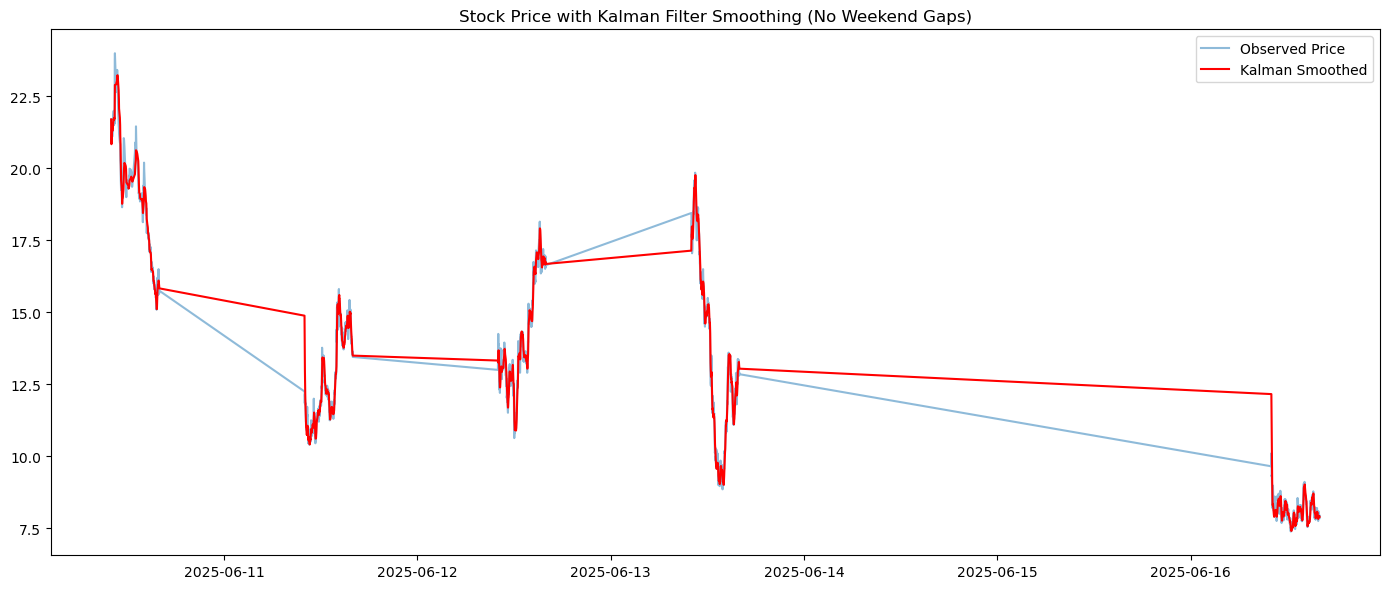

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
##___________________________________________________________________________________________________________________________________________________________________________________
days = 5 # or 7 for a full week
##___________________________________________________________________________________________________________________________________________________________________________________
# --- Data Preparation ---

# Remove weekends and keep only regular trading hours
datafix = data[data.index.weekday < 5]
datafix = datafix[(datafix.index.hour < 16) & (datafix.index.hour > 9)]

# Filter for only the last N days in the data
last_date = datafix.index.max()
timer = last_date - pd.Timedelta(days=days)
datafix = datafix[datafix.index >= timer]

# Ensure index is DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# --- Kalman Filter Price ---

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([datafix['Close'].iloc[0], 0.])  # initial state (price, velocity)
kf.F = np.array([[1., .1], [0., 1.]])            # state transition matrix
kf.H = np.array([[1., 0.]])                      # measurement function
kf.P *= 1000.                                    # covariance matrix
kf.R = 1.                                        # measurement noise
kf.Q = np.eye(2)*0.05                            # process noise

filtered_state_means = []
for price in datafix['Close']:
    kf.predict()
    kf.update(price)
    filtered_state_means.append(kf.x[0])

datafix['Kalman'] = filtered_state_means

# --- Plotting ---

plt.figure(figsize=(14,6))
plt.plot(datafix.index, datafix['Close'], label='Observed Price', alpha=0.5)
plt.plot(datafix.index, datafix['Kalman'], label='Kalman Smoothed', color='red')
plt.title('Stock Price with Kalman Filter Smoothing (No Weekend Gaps)')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
##KALMAN FILTER ROC
datafix["Kalman_Roc"] = datafix['Kalman'].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc
Date,,,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0,7.881647,0.765063
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0,7.892595,0.138902
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0,7.875281,-0.219375
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0,7.901762,0.336260
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0,7.909886,0.102812
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0,7.916629,0.085249
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0,7.911641,-0.063004
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0,7.921175,0.120500
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0,7.913050,-0.102566


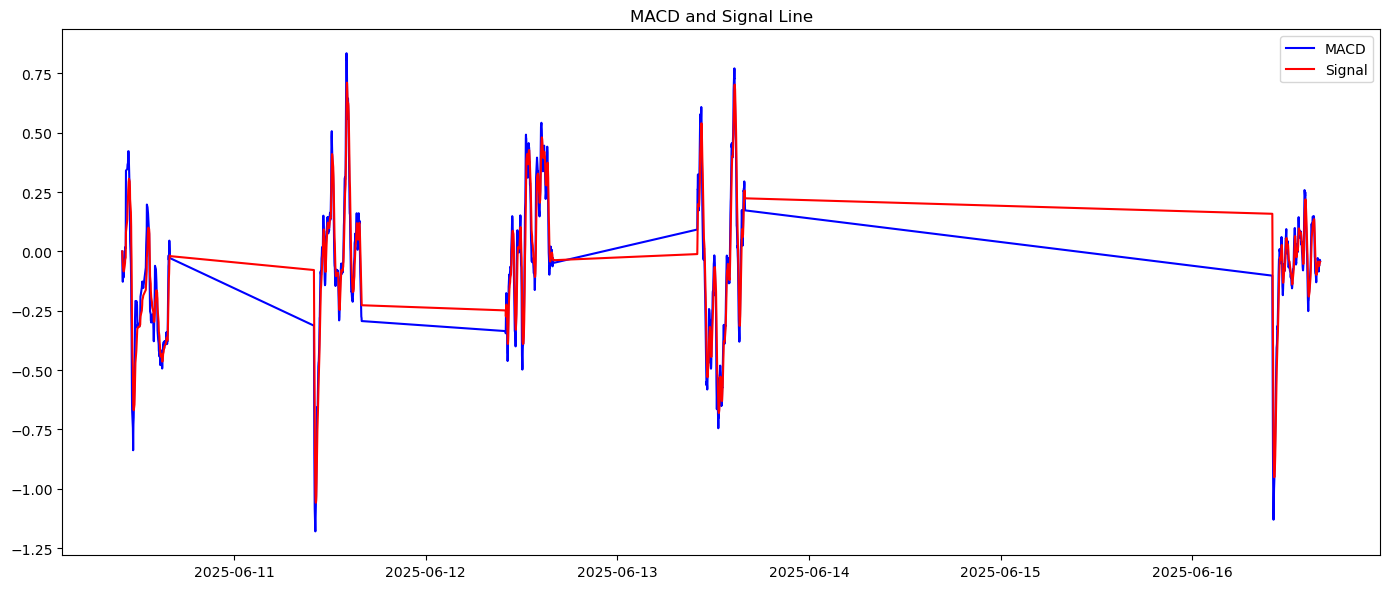

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist
Date,,,,,,,,,,
2025-06-10 10:00:00,21.70,21.70,21.70,21.70,100.0,21.700000,NaN,0.000000,0.000000,0.000000
2025-06-10 10:01:00,21.40,21.40,21.06,21.06,5.0,21.113465,-2.702925,-0.051054,-0.010211,-0.040843
2025-06-10 10:02:00,21.18,21.18,20.86,20.90,47.0,20.840492,-1.292888,-0.103236,-0.028816,-0.074420
2025-06-10 10:04:00,21.09,21.09,21.09,21.09,1.0,20.899860,0.284867,-0.127785,-0.048610,-0.079176
2025-06-10 10:05:00,21.40,21.40,21.40,21.40,3.0,21.127365,1.088549,-0.120834,-0.063054,-0.057779
2025-06-10 10:06:00,21.25,21.70,21.25,21.70,36.0,21.409797,1.336807,-0.090079,-0.068459,-0.021619
2025-06-10 10:07:00,21.50,21.52,21.50,21.52,2.0,21.480737,0.331345,-0.079315,-0.070631,-0.008685
2025-06-10 10:08:00,21.10,21.10,21.10,21.10,11.0,21.335017,-0.678374,-0.103483,-0.077201,-0.026282
2025-06-10 10:10:00,21.24,21.24,21.24,21.24,1.0,21.299337,-0.167239,-0.110070,-0.083775,-0.026295


In [12]:
#MACD
# Calculate MACD and Signal Line
def calculate_macd(df, close_col='Close', fast=12, slow=26, signal=9):
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - signal_line
    df['MACD'] = macd
    df['Signal'] = signal_line
    df['MACD_Hist'] = macd_hist
    return df

macdata = calculate_macd(datafix, close_col='Close', fast=12, slow=26, signal=9)

# Plotting MACD
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Split MACD histogram into positive and negative for color distinction
macd_hist = macdata['MACD_Hist']
pos_hist = macd_hist.copy()
neg_hist = macd_hist.copy()
pos_hist[pos_hist < 0] = 0
neg_hist[neg_hist > 0] = 0

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(macdata.index, macdata['MACD'], label='MACD', color='blue')
plt.plot(macdata.index, macdata['Signal'], label='Signal', color='red')
plt.title('MACD and Signal Line')
plt.legend()
plt.tight_layout()
plt.show()


macdata.head(10)


In [13]:
import pandas as pd
print(tvcontract)
## adjusting strike price for the contract

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2025, 6, 9)

# DGS1MO is the FRED code for the 1-Month Treasury Constant Maturity Rate
rate = web.DataReader('DGS1MO', 'fred', start, end)
rfr = rate.iloc[-1, 0]  # Last available value as a scalar



TSLA250620P330.0


In [14]:

dateexpiry = "2025-06-20"
#_________________________________________________________________________________________________________________________________
expiry = pd.Timestamp(dateexpiry)
datafix['days_to_expiry'] = expiry - datafix.index
print(datafix['days_to_expiry'].tail(1))
datafix['days_to_expiry'] = datafix['days_to_expiry'].dt.days.astype(float) +1

display(HTML(html))
datafix.tail(10)

Date
2025-06-16 15:59:00   3 days 08:01:00
Name: days_to_expiry, dtype: timedelta64[ns]


contractSymbol,lastTradeDate,strike,type,expiry,lastPrice,bid,ask,volume,openInterest,impliedVolatility
TSLA250620C00005000,2025-06-16 19:41:40+00:00,5.0,call,2025-06-20,324.01,323.15,324.90,15.0,1492.0,19.671879
TSLA250620P00005000,2025-06-16 13:30:02+00:00,5.0,put,2025-06-20,0.01,0.00,0.01,4.0,24272.0,10.750003
TSLA250620C00010000,2025-06-13 13:41:20+00:00,10.0,call,2025-06-20,307.00,318.15,319.90,50.0,1086.0,15.453125
TSLA250620P00010000,2025-06-16 14:17:21+00:00,10.0,put,2025-06-20,0.01,0.00,0.01,2.0,11049.0,8.750005
TSLA250620C00015000,2025-06-12 13:30:06+00:00,15.0,call,2025-06-20,308.69,313.15,314.95,1.0,81.0,13.460939
TSLA250620P00015000,2025-05-23 19:58:38+00:00,15.0,put,2025-06-20,0.01,0.00,0.01,2.0,35295.0,7.750000
TSLA250620C00020000,2025-06-11 17:36:09+00:00,20.0,call,2025-06-20,310.81,308.15,309.90,2.0,1088.0,11.898440
TSLA250620P00020000,2025-06-11 19:31:09+00:00,20.0,put,2025-06-20,0.01,0.00,0.01,14.0,29307.0,7.000001
TSLA250620P00025000,2025-06-06 19:58:56+00:00,25.0,put,2025-06-20,0.01,0.00,0.01,35.0,23561.0,6.500002
TSLA250620C00025000,2025-06-16 16:27:53+00:00,25.0,call,2025-06-20,306.23,303.15,304.90,1.0,156.0,10.847659


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry
Date,,,,,,,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0,7.881647,0.765063,-0.064050,-0.061621,-0.002429,4.0
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0,7.892595,0.138902,-0.058126,-0.060922,0.002796,4.0
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0,7.875281,-0.219375,-0.060800,-0.060898,0.000098,4.0
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0,7.901762,0.336260,-0.050236,-0.058765,0.008529,4.0
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0,7.909886,0.102812,-0.045376,-0.056087,0.010712,4.0
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0,7.916629,0.085249,-0.041050,-0.053080,0.012029,4.0
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0,7.911641,-0.063004,-0.040385,-0.050541,0.010156,4.0
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0,7.921175,0.120500,-0.035415,-0.047516,0.012101,4.0
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0,7.913050,-0.102566,-0.035903,-0.045193,0.009290,4.0


In [15]:
# get stock price


## Get the exchange correct from tradingview
stockdata = get_data(ticker, exchange="NASDAQ", interval="1", bars=5000)
#_______________________________________________________^EXCHANGE



In [16]:
stockdata.tail(10)

,Date,Open,High,Low,Close,Volume
4990,2025-06-16 19:50:00,329.61,329.99,328.85,328.92,40952.0
4991,2025-06-16 19:51:00,328.88,329.11,328.64,328.96,14677.0
4992,2025-06-16 19:52:00,328.98,329.63,328.75,329.49,34012.0
4993,2025-06-16 19:53:00,329.49,329.59,329.08,329.15,29437.0
4994,2025-06-16 19:54:00,329.14,329.39,328.97,329.26,24968.0
4995,2025-06-16 19:55:00,329.29,329.43,328.91,329.23,29591.0
4996,2025-06-16 19:56:00,329.24,329.31,328.97,329.25,18837.0
4997,2025-06-16 19:57:00,329.24,329.25,329.00,329.09,18070.0
4998,2025-06-16 19:58:00,329.09,329.09,328.92,328.97,21432.0
4999,2025-06-16 19:59:00,328.96,329.25,328.80,329.09,47351.0


In [17]:
import pandas as pd

# Adjust stockdata['Date'] and set as index
stockdata["Date"] = pd.to_datetime(stockdata["Date"]) - pd.Timedelta(hours=4)
stockdata = stockdata.set_index("Date").sort_index()
stockdata["stock price"] = stockdata["Close"]

# Ensure datafix index is datetime and sorted
datafix.index = pd.to_datetime(datafix.index)
datafix = datafix.sort_index()

# Use merge_asof with suffixes to control column names
merged = pd.merge_asof(
    datafix,
    stockdata[["Close"]],
    left_index=True,
    right_index=True,
    direction="nearest",
    suffixes=('_datafix', '_stock')
)

# Rename columns: Close_datafix → Close, Close_stock → stock price
merged = merged.rename(columns={
    'Close_datafix': 'Close',
    'Close_stock': 'stock price'
})

# Assign merged DataFrame back to datafix
datafix = merged

# Show the last 10 rows
datafix.tail(10)


,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price
Date,,,,,,,,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0,7.881647,0.765063,-0.064050,-0.061621,-0.002429,4.0,328.92
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0,7.892595,0.138902,-0.058126,-0.060922,0.002796,4.0,328.96
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0,7.875281,-0.219375,-0.060800,-0.060898,0.000098,4.0,329.49
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0,7.901762,0.336260,-0.050236,-0.058765,0.008529,4.0,329.15
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0,7.909886,0.102812,-0.045376,-0.056087,0.010712,4.0,329.26
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0,7.916629,0.085249,-0.041050,-0.053080,0.012029,4.0,329.23
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0,7.911641,-0.063004,-0.040385,-0.050541,0.010156,4.0,329.25
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0,7.921175,0.120500,-0.035415,-0.047516,0.012101,4.0,329.09
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0,7.913050,-0.102566,-0.035903,-0.045193,0.009290,4.0,328.97


In [18]:



# set strike for black scholes 
datafix['strike'] = 330  
datafix['rfr'] = rfr/100
# Define the type of option
datafix["type"] = "p"
##___________________________________________________________________________________________________________________________________________________________________________________

datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type
Date,,,,,,,,,,,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0,7.881647,0.765063,-0.064050,-0.061621,-0.002429,4.0,328.92,330,0.0429,p
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0,7.892595,0.138902,-0.058126,-0.060922,0.002796,4.0,328.96,330,0.0429,p
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0,7.875281,-0.219375,-0.060800,-0.060898,0.000098,4.0,329.49,330,0.0429,p
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0,7.901762,0.336260,-0.050236,-0.058765,0.008529,4.0,329.15,330,0.0429,p
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0,7.909886,0.102812,-0.045376,-0.056087,0.010712,4.0,329.26,330,0.0429,p
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0,7.916629,0.085249,-0.041050,-0.053080,0.012029,4.0,329.23,330,0.0429,p
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0,7.911641,-0.063004,-0.040385,-0.050541,0.010156,4.0,329.25,330,0.0429,p
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0,7.921175,0.120500,-0.035415,-0.047516,0.012101,4.0,329.09,330,0.0429,p
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0,7.913050,-0.102566,-0.035903,-0.045193,0.009290,4.0,328.97,330,0.0429,p


In [19]:
print(tvcontract)

TSLA250620P330.0


In [20]:


import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_price(S, K, T, r, sigma, option_type='c'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility_row(row):
    price = row['Close']
    S = row['stock price']
    K = row['strike']
    T = row['days_to_expiry'] / 365.0
    r = row['rfr']
    option_type = row['type']  # 'c' for call, 'p' for put

    # Objective function for root finding
    def objective(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - price

    try:
        return brentq(objective, 1e-6, 5.0)
    except Exception:
        return np.nan

datafix['IV'] = datafix.apply(implied_volatility_row, axis=1)



In [21]:
datafix["IVROC"] = datafix["IV"].pct_change().dropna() * 100  # Convert to percentage change
datafix.tail(10)

,Open,High,Low,Close,Volume,Kalman,Kalman_Roc,MACD,Signal,MACD_Hist,days_to_expiry,stock price,strike,rfr,type,IV,IVROC
Date,,,,,,,,,,,,,,,,,
2025-06-16 15:50:00,7.65,8.09,7.61,8.09,111.0,7.881647,0.765063,-0.064050,-0.061621,-0.002429,4.0,328.92,330,0.0429,p,0.553915,-0.005753
2025-06-16 15:51:00,8.10,8.20,7.95,7.95,45.0,7.892595,0.138902,-0.058126,-0.060922,0.002796,4.0,328.96,330,0.0429,p,0.545201,-1.573287
2025-06-16 15:52:00,8.15,8.15,7.85,7.85,12.0,7.875281,-0.219375,-0.060800,-0.060898,0.000098,4.0,329.49,330,0.0429,p,0.557260,2.211919
2025-06-16 15:53:00,7.85,8.00,7.80,8.00,52.0,7.901762,0.336260,-0.050236,-0.058765,0.008529,4.0,329.15,330,0.0429,p,0.555824,-0.257786
2025-06-16 15:54:00,8.00,8.05,7.90,7.95,57.0,7.909886,0.102812,-0.045376,-0.056087,0.010712,4.0,329.26,330,0.0429,p,0.556201,0.067876
2025-06-16 15:55:00,8.00,8.05,7.95,7.95,35.0,7.916629,0.085249,-0.041050,-0.053080,0.012029,4.0,329.23,330,0.0429,p,0.555108,-0.196478
2025-06-16 15:56:00,7.97,8.05,7.90,7.91,84.0,7.911641,-0.063004,-0.040385,-0.050541,0.010156,4.0,329.25,330,0.0429,p,0.552928,-0.392765
2025-06-16 15:57:00,7.97,8.00,7.85,7.96,17.0,7.921175,0.120500,-0.035415,-0.047516,0.012101,4.0,329.09,330,0.0429,p,0.550715,-0.400206
2025-06-16 15:58:00,8.00,8.00,7.90,7.90,64.0,7.913050,-0.102566,-0.035903,-0.045193,0.009290,4.0,328.97,330,0.0429,p,0.541930,-1.595167


In [22]:
# Ensure your index is a DatetimeIndex
datafix.index = pd.to_datetime(datafix.index)

# Filter for weekdays (Monday=0, Sunday=6)
is_weekday = datafix.index.dayofweek < 5

# Filter for regular trading hours (9:30 to 16:00)
is_regular_hours = (
    (datafix.index.hour > 9) & (datafix.index.hour < 16) |  # 10:00 to 15:59
    ((datafix.index.hour == 9) & (datafix.index.minute >= 30)) |  # 9:30 to 9:59
    ((datafix.index.hour == 16) & (datafix.index.minute == 0))    # exactly 16:00
)

# Combine masks
mask = is_weekday & is_regular_hours

# Apply mask to keep only regular trading hours
datafix = datafix.loc[mask]


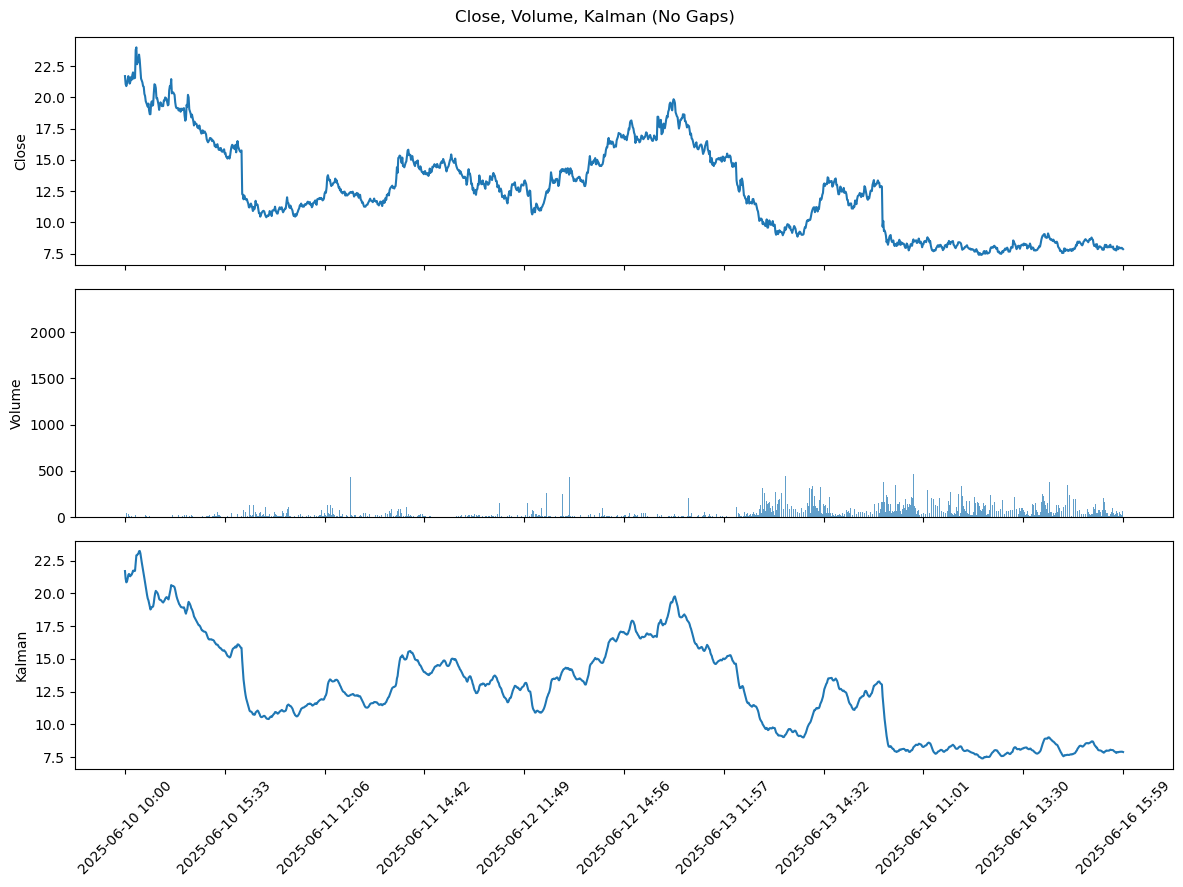

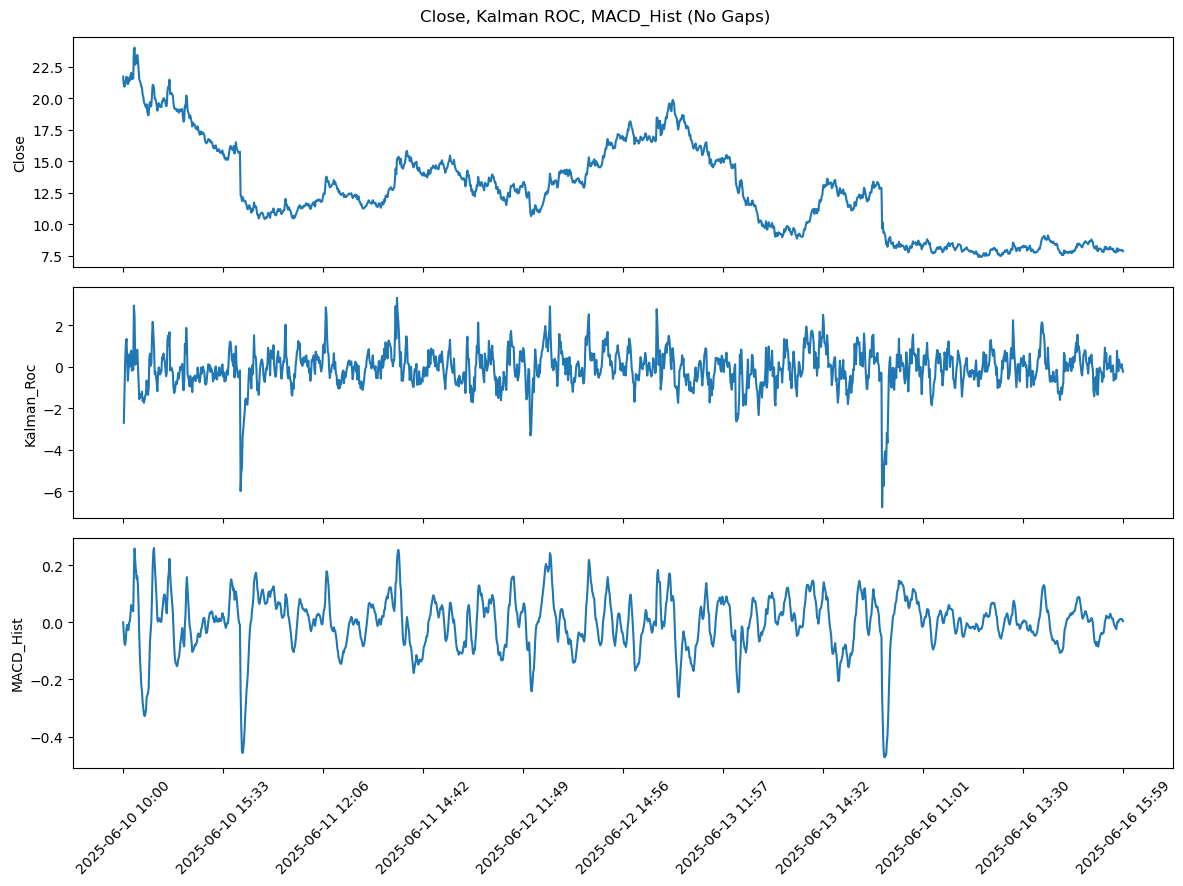

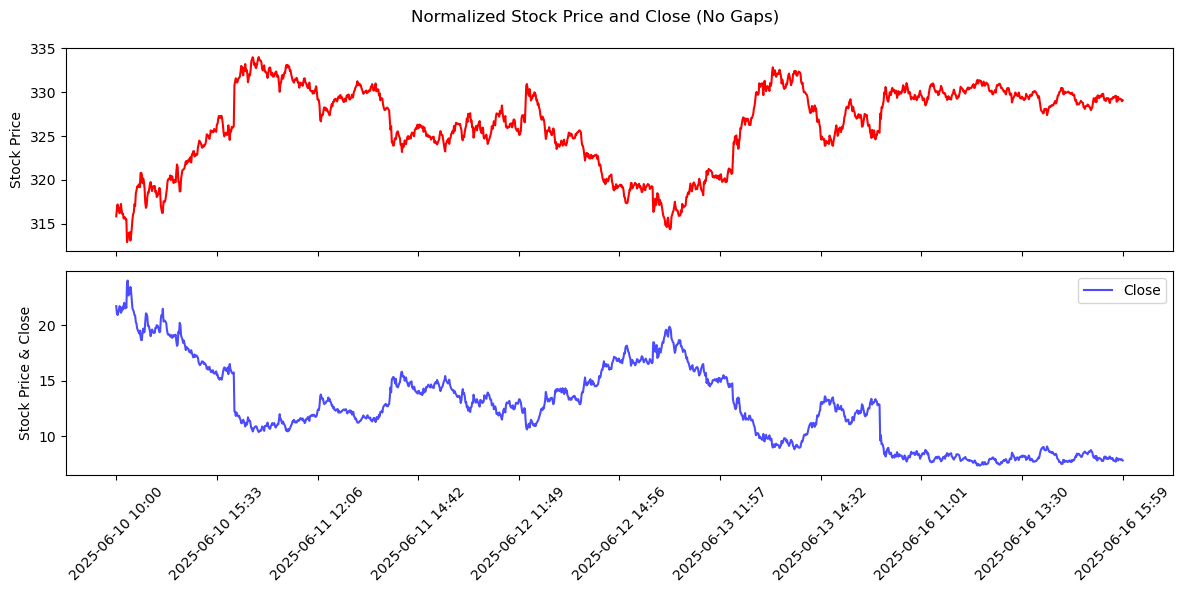

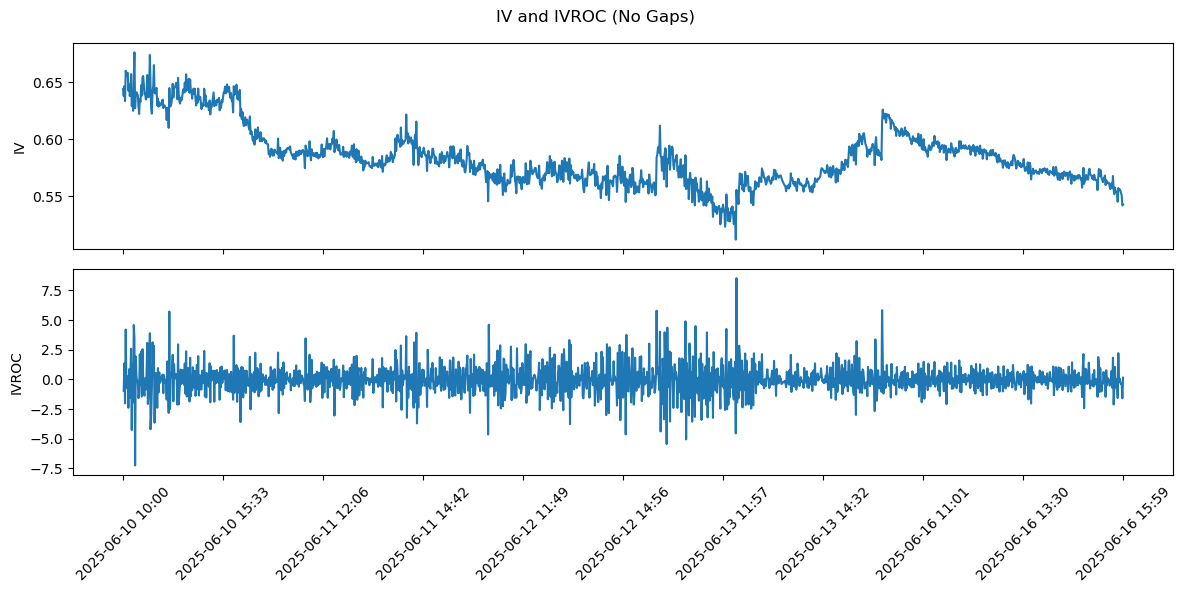

In [23]:
import matplotlib.pyplot as plt

# Reset index and detect the datetime column name
datafix_reset = datafix.reset_index()
datetime_col = datafix_reset.columns[0]  # The first column after reset_index() is always the old index

# For tick labeling, use the datetime column
time_labels = datafix_reset[datetime_col]

# Function to plot with integer index and datetime tick labels
def plot_with_int_index(y_cols, suptitle, kinds=None):
    n = len(y_cols)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
    if n == 1:
        axs = [axs]
    for i, col in enumerate(y_cols):
        kind = 'line' if not kinds else kinds[i]
        if kind == 'bar':
            axs[i].bar(datafix_reset.index, datafix_reset[col], label=col, alpha=0.7)
        else:
            axs[i].plot(datafix_reset.index, datafix_reset[col], label=col)
        axs[i].set_ylabel(col)
    # Set x-ticks with datetime labels
    step = max(1, len(time_labels) // 10)
    axs[-1].set_xticks(datafix_reset.index[::step])
    axs[-1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

# 1. Close, Volume (bar), Kalman
plot_with_int_index(['Close', 'Volume', 'Kalman'], 'Close, Volume, Kalman (No Gaps)', kinds=['line', 'bar', 'line'])

# 2. Close, Kalman_Roc, MACD_Hist (bar)
plot_with_int_index(['Close', 'Kalman_Roc', 'MACD_Hist'], 'Close, Kalman ROC, MACD_Hist (No Gaps)', kinds=['line', 'line', 'line'])
import pandas as pd
from sklearn.preprocessing import StandardScaler
#3. Prices

# Overlay plot: normalized stock price and close
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(datafix_reset.index, datafix['stock price'], label='Stock Price ', color='red')
axs[0].set_ylabel('Stock Price')
axs[1].plot(datafix_reset.index, datafix['Close'], label='Close', color='blue', alpha=0.7)
axs[1].set_ylabel('Stock Price & Close')
axs[1].legend()
step = max(1, len(time_labels) // 10)
axs[1].set_xticks(datafix_reset.index[::step])
axs[1].set_xticklabels([t.strftime('%Y-%m-%d %H:%M') for t in time_labels[::step]], rotation=45)
plt.suptitle('Normalized Stock Price and Close (No Gaps)')
plt.tight_layout()
plt.show()


# 4. IV, IVROC
plot_with_int_index(['IV', 'IVROC'], 'IV and IVROC (No Gaps)')


In [24]:
# kalman filter (Garch) the IV
# Pull price data from fidelity csv 
# set thresholds 
# figure out papertrade setup 

In [25]:
import os

# Assume 'datafix' is your pandas DataFrame
# import pandas as pd
# datafix = pd.DataFrame(...)  # your DataFrame creation

user_input = input("Download datafix.csv to Desktop? (y/n): ").strip().lower()

if user_input == 'y':
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
    file_path = os.path.join(desktop_path, "datafix.csv")
    try:
        datafix.to_csv(file_path, index=True)
        print(f"datafix.csv saved to {file_path} (including index)")
    except Exception as e:
        print(f"Failed to save CSV: {e}")
else:
    print("Download canceled.")


datafix.csv saved to /Users/nshaffer/Desktop/datafix.csv (including index)


In [26]:
# get a garch or volatility measure to make trades when IV is low (and increasing?)